# Check PCA decom

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from numpy.linalg import inv, eig, pinv
from scipy import linalg
from scipy import pi, multiply, power, tanh, exp, cosh
from scipy import random

In [2]:
import tensorly as tl  # import this to help plotting

Using numpy backend.


In [3]:
# This is the pcp(Principal Projection Pursuit) function from https://github.com/dfm/pcp

"""
An implementation of the Principal Component Pursuit algorithm for robust PCA
as described in `Candes, Li, Ma, & Wright <http://arxiv.org/abs/0912.3599>`_.
An alternative Python implementation using non-standard dependencies and
different hyperparameter choices is available at:
http://blog.shriphani.com/2013/12/18/
    robust-principal-component-pursuit-background-matrix-recovery/
"""

from __future__ import division, print_function

__all__ = ["pcp"]

import time
# import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        # step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

## Load MVBS from HDF5 file

In [4]:
MVBS_path = '../sample_data'
MVBS_fname = '20150817-20151017_MVBS.h5'

In [5]:
# Reading 2-month sonar time series
import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),"r")
MVBS = np.array(f['MVBS'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_time = np.array(f['ping_time'])
f.close()

In [6]:
ping_per_day_mvbs = 144

Note that below all lower case variables (e.g., `mvbs`, `mvbs_long`) are in the linear domain and all upper case variables (e.g., `MVBS`) are in the log domain.

In [7]:
mvbs = 10**(MVBS[:,1:-2,:]/10)  # 62-day stretch
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

Let's take a look at the original data.

In [8]:
mvbs_long.shape

(62, 15984)

In [9]:
MVBS_long = 10*np.log10(mvbs_long)

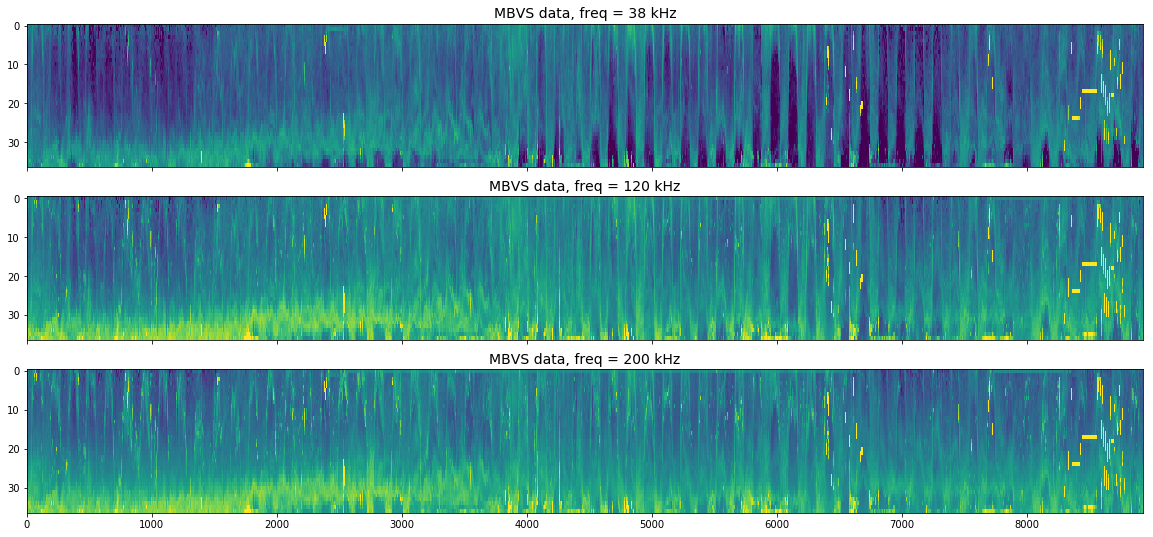

In [10]:
len_1freq = ping_per_day_mvbs*37
idx_vec = np.arange(len_1freq)

fig = plt.figure(figsize=(20,9))
ax1 = fig.add_subplot(311)
plt.imshow(tl.unfold(tl.tensor(MVBS_long[:,idx_vec].reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto', vmin=-90, vmax=-40)
plt.title('MBVS data, freq = 38 kHz', fontsize=14)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(312, sharex=ax1)
plt.imshow(tl.unfold(tl.tensor(MVBS_long[:,len_1freq+idx_vec].reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto', vmin=-90, vmax=-40)
plt.title('MBVS data, freq = 120 kHz', fontsize=14)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = fig.add_subplot(313, sharex = ax1)
plt.imshow(tl.unfold(tl.tensor(MVBS_long[:,len_1freq*2+idx_vec].reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto', vmin=-90, vmax=-40)
plt.title('MBVS data, freq = 200 kHz', fontsize=14)

plt.show()

In the decomposition below we will use data from all frequencies (cancatenated into a giant matrix: `mvbs_long` computed above), but we will show only results from the first frequency since the others are broadly similar.

## Robust PCA (regular PCP) in the log domain

Below we run regular PCP in the log domain. Note the svd_method is "exact". We will inspect both the low-rank (`L`) and sparse (`S`) components, as well as the `u`, `s`, `v` components which are intermediate outputs from PCP.

In [11]:
%%time
# applying pcp to the data in log domain (i.e. the way data comes from OOI)
L_log, S_log, (u_log,s_log,v_log) = pcp(10*np.log10(mvbs_long),maxiter=500, verbose=True,svd_method="exact")

mu = 0.0036529179686318465
Iteration 0: error=2.042e-02, rank=60, nnz=86920, time=1.151e-01
Iteration 1: error=4.469e-03, rank=62, nnz=137771, time=9.359e-02
Iteration 2: error=3.343e-03, rank=62, nnz=178503, time=6.577e-02
Iteration 3: error=2.917e-03, rank=62, nnz=214642, time=5.934e-02
Iteration 4: error=2.622e-03, rank=57, nnz=245903, time=8.959e-02
Iteration 5: error=2.351e-03, rank=51, nnz=271841, time=6.517e-02
Iteration 6: error=2.095e-03, rank=44, nnz=291950, time=7.963e-02
Iteration 7: error=1.859e-03, rank=38, nnz=307355, time=6.087e-02
Iteration 8: error=1.643e-03, rank=35, nnz=319053, time=9.125e-02
Iteration 9: error=1.447e-03, rank=33, nnz=327957, time=7.743e-02
Iteration 10: error=1.269e-03, rank=31, nnz=334789, time=7.505e-02
Iteration 11: error=1.108e-03, rank=30, nnz=340066, time=6.635e-02
Iteration 12: error=9.647e-04, rank=30, nnz=344129, time=9.353e-02
Iteration 13: error=8.368e-04, rank=29, nnz=347195, time=6.032e-02
Iteration 14: error=7.240e-04, rank=29, nnz=34

### Plot low-rank and sparse components

Let's first take a look at the raw output to figure out how to reshape the matrices.

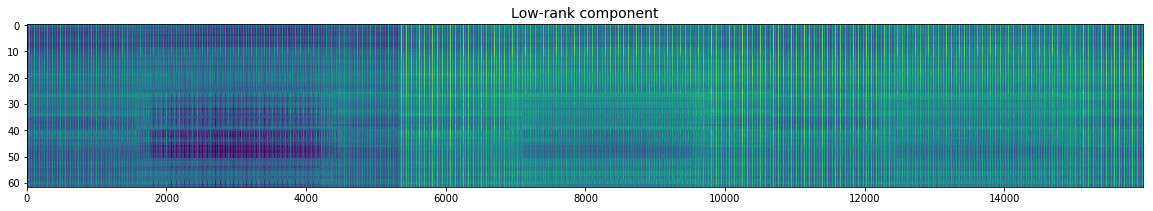

In [12]:
plt.figure(figsize=(20, 3))
plt.imshow(L_log, aspect='auto', vmin=-90, vmax=-40)
plt.title('Low-rank component', fontsize=14)
plt.show()

In [13]:
L_log.shape

(62, 15984)

In [14]:
ping_per_day_mvbs

144

It appears that the three frequencies are concatenated along dimension 0. We know there are 144 pings per day, and each ping contains 37 depth bins. Therefore we can retrieve and reshape data at the first frequency (38 kHz) below:

In [15]:
L_log_freq1 = L_log[:,:ping_per_day_mvbs*37]
L_log_freq1.reshape(62,ping_per_day_mvbs,37).shape

(62, 144, 37)

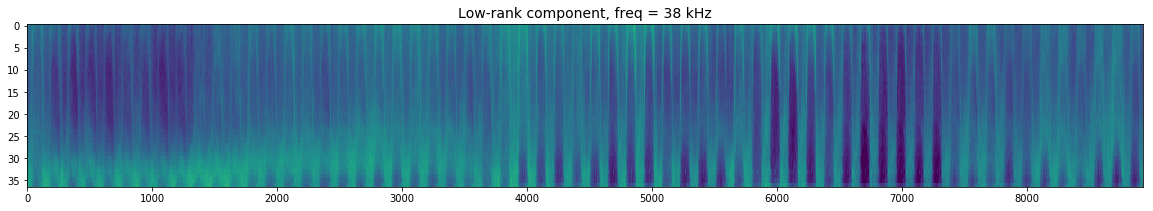

In [16]:
plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(L_log_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto', vmin=-90, vmax=-40)
plt.title('Low-rank component, freq = 38 kHz', fontsize=14)
plt.show()

We can do the same reshaping for the sparse component:

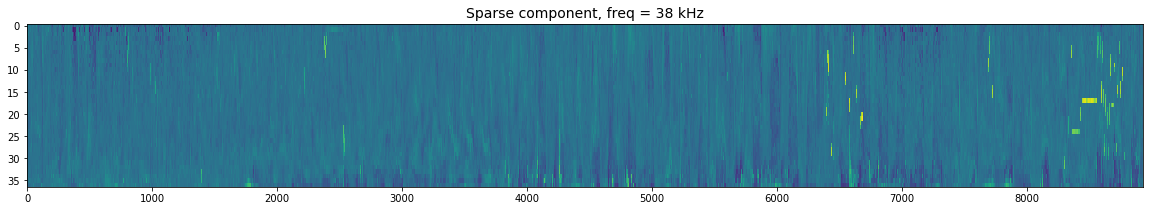

In [17]:
S_log_freq1 = S_log[:,:ping_per_day_mvbs*37]
S_log_freq1.reshape(62,ping_per_day_mvbs,37).shape

plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(S_log_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('Sparse component, freq = 38 kHz', fontsize=14)
plt.show()

### Reconstruct PCA components of the low-rank component

We next try to reconstruct from individual `u_log`, `s_log`, `v_log` components produced by regular PCA of `L_log`.

We first check the dimension of the matrices to make sure we know what's going on.

In [18]:
(u_log.shape, s_log.shape, v_log.shape)

((62, 32), (32,), (32, 15984))

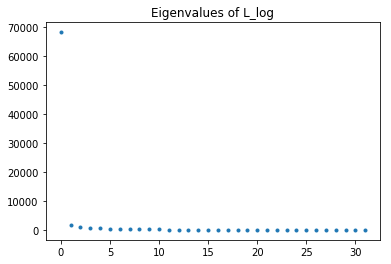

In [19]:
plt.plot(s_log,'.')
plt.title('Eigenvalues of L_log')
plt.show()

We can see that the first eigenvalue is orders of magnitude largers than the rest. This means that the `L_log` matrix is very low-rank.

Below we start reconstructing the first component at the first frequency.

In [20]:
C0 = np.expand_dims(u_log[:,0]*s_log[0],axis=1)*v_log[0,:].T

In [21]:
C0.shape

(62, 15984)

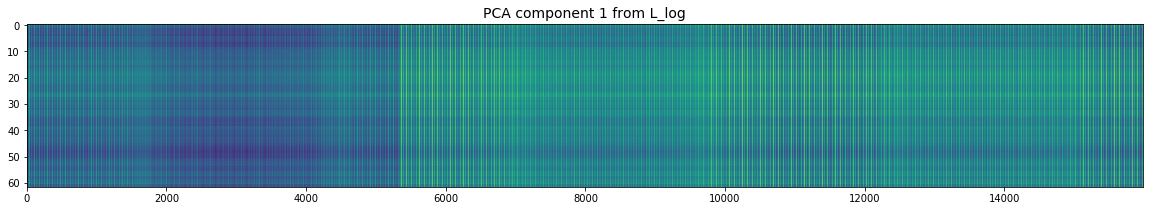

In [22]:
plt.figure(figsize=(20, 3))
plt.imshow(C0, aspect='auto', vmin=-90, vmax=-40)
plt.title('PCA component 1 from L_log', fontsize=14)
plt.show()

Again let's retrieve and reshape the first frequency of this PCA component.

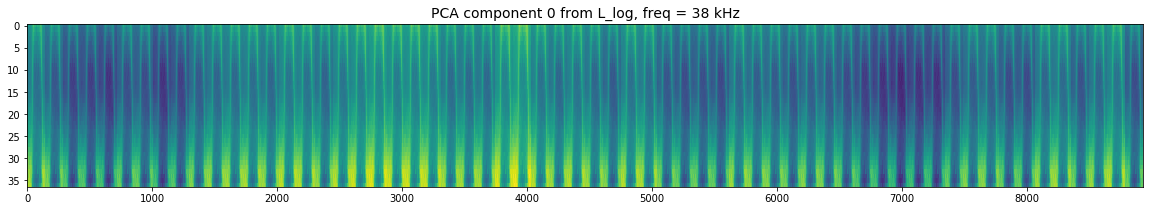

In [23]:
# Component 0
C0_freq1 = C0[:,:ping_per_day_mvbs*37]
plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(C0_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('PCA component 0 from L_log, freq = 38 kHz', fontsize=14)
plt.show()

Let's take a look at the subsequent components:

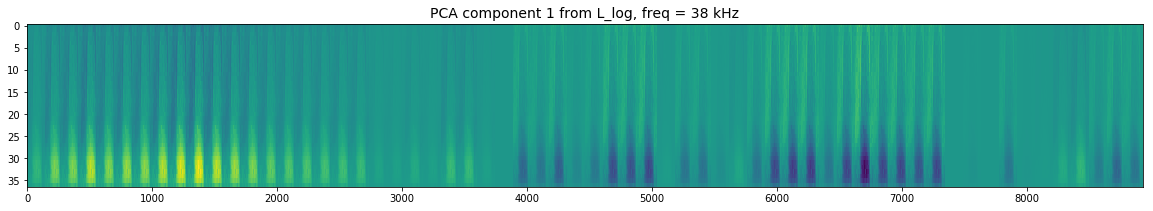

In [24]:
# Component 1
C1 = np.expand_dims(u_log[:,1]*s_log[1],axis=1)*v_log[1,:].T
C1_freq1 = C1[:,:ping_per_day_mvbs*37]

plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(C1_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('PCA component 1 from L_log, freq = 38 kHz', fontsize=14)
plt.show()

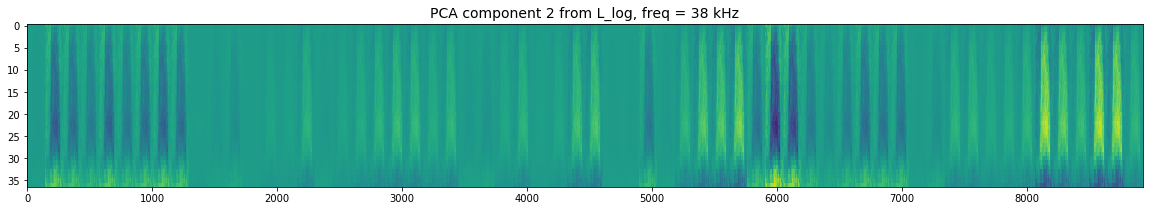

In [25]:
# Component 2
C2 = np.expand_dims(u_log[:,2]*s_log[2],axis=1)*v_log[2,:].T
C2_freq1 = C2[:,:ping_per_day_mvbs*37]

plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(C2_freq1.reshape(62,ping_per_day_mvbs,37).squeeze()),mode=2), 
           aspect='auto')
plt.title('PCA component 2 from L_log, freq = 38 kHz', fontsize=14)
plt.show()

These 3 components seem to capture different features in the data, but it is curious that the first eigenvalue is so much stronger than the others, especially since `L_log` is low-rank.

## Robust PCA (regular PCP) in the linear domain¶

Here we run the same PCP decomposition as before, but the data is in the linear domain. Note we push down the tolerance `delta` to force the algorithm to run longer.

In [26]:
%%time
# applying pcp to the data in linear domain (i.e. the way data comes from ooi)
L_lin, S_lin, (u_lin,s_lin,v_lin) = pcp(mvbs_long,maxiter=500, verbose=True,svd_method="exact",delta=1e-7)

mu = 3316.7426267274345
Iteration 0: error=8.016e-05, rank=52, nnz=13502, time=1.240e-01
Iteration 1: error=3.704e-05, rank=45, nnz=23169, time=9.195e-02
Iteration 2: error=3.092e-05, rank=40, nnz=32911, time=7.052e-02
Iteration 3: error=2.917e-05, rank=36, nnz=42225, time=8.164e-02
Iteration 4: error=2.621e-05, rank=34, nnz=50701, time=1.850e-01
Iteration 5: error=2.282e-05, rank=34, nnz=58943, time=1.494e-01
Iteration 6: error=2.171e-05, rank=34, nnz=66590, time=1.217e-01
Iteration 7: error=2.294e-05, rank=31, nnz=73599, time=1.060e-01
Iteration 8: error=2.404e-05, rank=30, nnz=80579, time=8.486e-02
Iteration 9: error=2.364e-05, rank=28, nnz=87327, time=8.197e-02
Iteration 10: error=2.203e-05, rank=26, nnz=93850, time=7.961e-02
Iteration 11: error=1.960e-05, rank=25, nnz=100431, time=9.013e-02
Iteration 12: error=1.655e-05, rank=25, nnz=106672, time=8.001e-02
Iteration 13: error=1.443e-05, rank=25, nnz=112569, time=9.521e-02
Iteration 14: error=1.268e-05, rank=25, nnz=118074, time=8.

Iteration 122: error=9.762e-07, rank=27, nnz=285805, time=7.139e-02
Iteration 123: error=9.658e-07, rank=27, nnz=286290, time=8.686e-02
Iteration 124: error=9.552e-07, rank=27, nnz=286778, time=7.047e-02
Iteration 125: error=9.447e-07, rank=27, nnz=287283, time=6.981e-02
Iteration 126: error=9.348e-07, rank=28, nnz=287729, time=7.274e-02
Iteration 127: error=9.211e-07, rank=28, nnz=288129, time=6.971e-02
Iteration 128: error=9.091e-07, rank=28, nnz=288574, time=7.069e-02
Iteration 129: error=8.995e-07, rank=28, nnz=289005, time=7.203e-02
Iteration 130: error=8.910e-07, rank=28, nnz=289416, time=7.710e-02
Iteration 131: error=8.825e-07, rank=28, nnz=289810, time=7.169e-02
Iteration 132: error=8.735e-07, rank=28, nnz=290218, time=7.418e-02
Iteration 133: error=8.648e-07, rank=28, nnz=290614, time=6.878e-02
Iteration 134: error=8.562e-07, rank=28, nnz=291066, time=8.290e-02
Iteration 135: error=8.478e-07, rank=28, nnz=291483, time=8.032e-02
Iteration 136: error=8.402e-07, rank=28, nnz=291

Iteration 244: error=1.246e-06, rank=29, nnz=321718, time=7.379e-02
Iteration 245: error=1.142e-06, rank=29, nnz=322097, time=6.943e-02
Iteration 246: error=1.111e-06, rank=29, nnz=322486, time=7.212e-02
Iteration 247: error=1.086e-06, rank=30, nnz=322832, time=8.243e-02
Iteration 248: error=1.062e-06, rank=30, nnz=323167, time=7.771e-02
Iteration 249: error=1.042e-06, rank=30, nnz=323478, time=6.786e-02
Iteration 250: error=1.026e-06, rank=30, nnz=323800, time=7.097e-02
Iteration 251: error=1.016e-06, rank=30, nnz=324063, time=7.664e-02
Iteration 252: error=1.007e-06, rank=30, nnz=324370, time=7.062e-02
Iteration 253: error=9.988e-07, rank=30, nnz=324598, time=6.972e-02
Iteration 254: error=9.930e-07, rank=30, nnz=324827, time=6.949e-02
Iteration 255: error=9.865e-07, rank=30, nnz=325079, time=7.683e-02
Iteration 256: error=9.791e-07, rank=30, nnz=325351, time=7.522e-02
Iteration 257: error=9.761e-07, rank=30, nnz=325616, time=7.211e-02
Iteration 258: error=9.684e-07, rank=30, nnz=325

Iteration 366: error=1.672e-06, rank=28, nnz=346250, time=6.866e-02
Iteration 367: error=1.583e-06, rank=28, nnz=347054, time=7.776e-02
Iteration 368: error=1.512e-06, rank=29, nnz=347872, time=7.179e-02
Iteration 369: error=1.488e-06, rank=29, nnz=348619, time=7.067e-02
Iteration 370: error=1.445e-06, rank=29, nnz=349323, time=6.990e-02
Iteration 371: error=1.334e-06, rank=29, nnz=350007, time=7.577e-02
Iteration 372: error=1.283e-06, rank=29, nnz=350642, time=6.807e-02
Iteration 373: error=1.238e-06, rank=29, nnz=351219, time=6.933e-02
Iteration 374: error=1.205e-06, rank=29, nnz=351799, time=6.869e-02
Iteration 375: error=1.181e-06, rank=29, nnz=352312, time=7.364e-02
Iteration 376: error=1.201e-06, rank=29, nnz=352807, time=7.300e-02
Iteration 377: error=3.332e-06, rank=29, nnz=353230, time=8.499e-02
Iteration 378: error=1.160e-06, rank=29, nnz=353621, time=8.089e-02
Iteration 379: error=1.101e-06, rank=29, nnz=353975, time=7.823e-02
Iteration 380: error=1.108e-06, rank=29, nnz=354

Iteration 488: error=5.234e-07, rank=31, nnz=374036, time=7.567e-02
Iteration 489: error=5.110e-07, rank=31, nnz=374176, time=8.539e-02
Iteration 490: error=6.697e-07, rank=31, nnz=374296, time=8.541e-02
Iteration 491: error=4.838e-07, rank=31, nnz=374423, time=7.403e-02
Iteration 492: error=4.742e-07, rank=31, nnz=374527, time=1.038e-01
Iteration 493: error=4.625e-07, rank=31, nnz=374621, time=7.323e-02
Iteration 494: error=4.490e-07, rank=31, nnz=374741, time=6.982e-02
Iteration 495: error=4.354e-07, rank=31, nnz=374843, time=7.296e-02
Iteration 496: error=4.295e-07, rank=31, nnz=374969, time=7.490e-02
Iteration 497: error=4.265e-07, rank=31, nnz=375082, time=7.037e-02


/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:89: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


Iteration 498: error=4.214e-07, rank=31, nnz=375194, time=7.023e-02
Iteration 499: error=4.171e-07, rank=31, nnz=375310, time=7.016e-02
CPU times: user 1min 46s, sys: 10.9 s, total: 1min 57s
Wall time: 1min


We can see that the rank of the low-rank component stablizes but still fluctuates with increasing number of runs.

### Plot low-rank and sparse components

Let's first take a look at the raw output from PCP:

/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


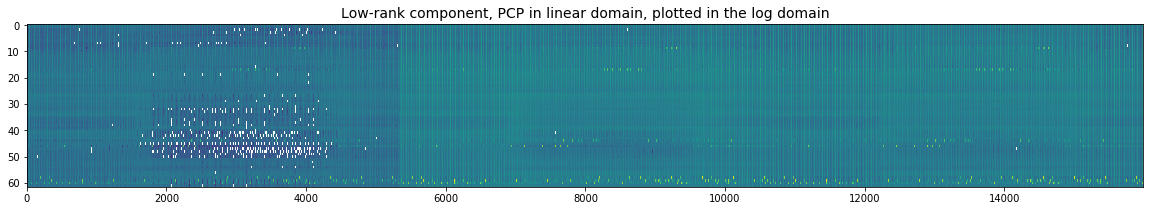

In [27]:
plt.figure(figsize=(20, 3))
plt.imshow(10*np.log10(L_lin), aspect='auto')
plt.title('Low-rank component, PCP in linear domain, plotted in the log domain', fontsize=14)
plt.show()

In [28]:
L_lin_freq1 = L_lin[:,:ping_per_day_mvbs*37]
L_lin_freq1.reshape(62,ping_per_day_mvbs,37).shape

(62, 144, 37)

/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


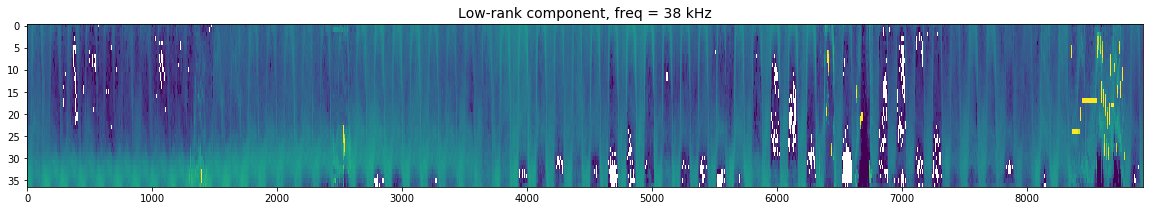

In [29]:
plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(10*np.log10(L_lin_freq1.reshape(62,ping_per_day_mvbs,37)).squeeze()),mode=2), 
           aspect='auto', vmin=-90, vmax=-40)
plt.title('Low-rank component, freq = 38 kHz', fontsize=14)
plt.show()

We can do the same reshaping for the sparse component:

/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


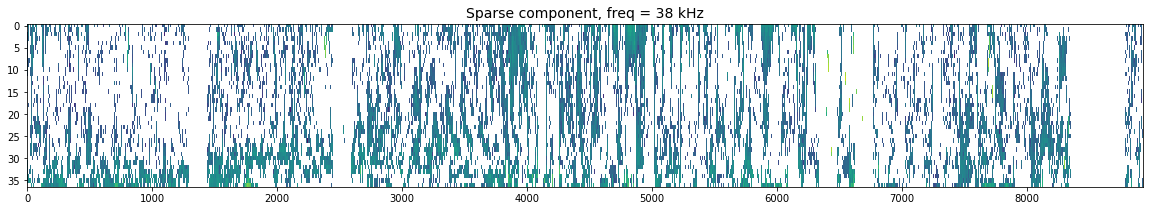

In [30]:
S_lin_freq1 = S_lin[:,:ping_per_day_mvbs*37]
S_lin_freq1.reshape(62,ping_per_day_mvbs,37).shape

plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(10*np.log10(S_lin_freq1.reshape(62,ping_per_day_mvbs,37)).squeeze()),mode=2), 
           aspect='auto')
plt.title('Sparse component, freq = 38 kHz', fontsize=14)
plt.show()

### Reconstruct the PCA components of the low-rank component

Let's take a look at the eigenvalue again: the changes are much more gradual than in the case in the logdomain.

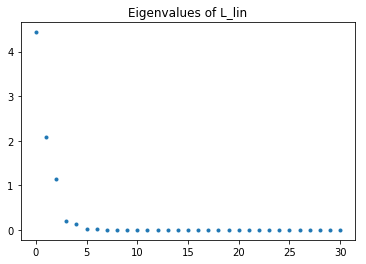

In [31]:
plt.plot(s_lin,'.')
plt.title('Eigenvalues of L_lin')
plt.show()

In [32]:
C0_lin = np.expand_dims(u_lin[:,0]*s_lin[0],axis=1)*v_lin[0,:].T

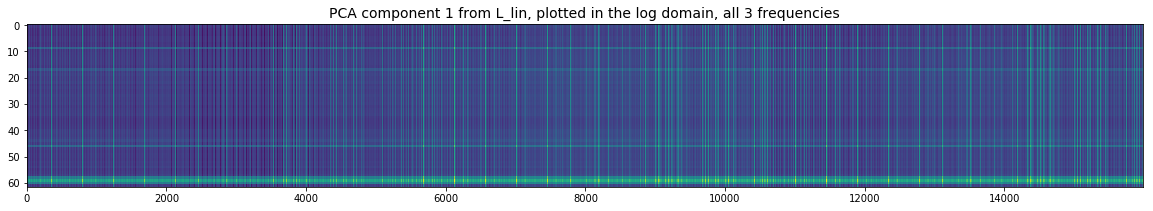

In [33]:
plt.figure(figsize=(20, 3))
plt.imshow(10*np.log10(C0_lin), aspect='auto')
plt.title('PCA component 1 from L_lin, plotted in the log domain, all 3 frequencies', fontsize=14)
plt.show()

Again let's retrieve and reshape the first frequency of this PCA component.

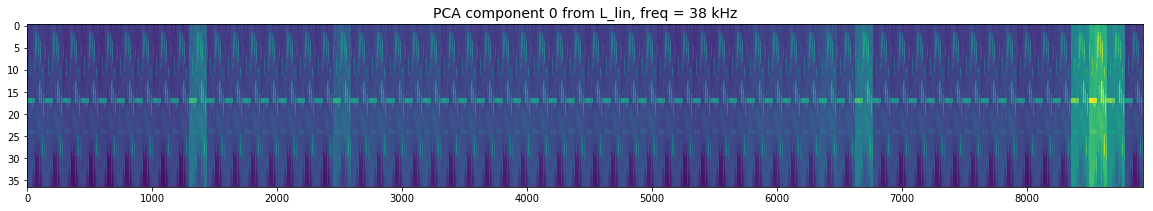

In [34]:
# Component 0
C0_lin_freq1 = C0_lin[:,:ping_per_day_mvbs*37]
plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(10*np.log10(C0_lin_freq1.reshape(62,ping_per_day_mvbs,37)).squeeze()),mode=2), 
           aspect='auto')
plt.title('PCA component 0 from L_lin, freq = 38 kHz', fontsize=14)
plt.show()

Let's take a look at the subsequent components:

/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


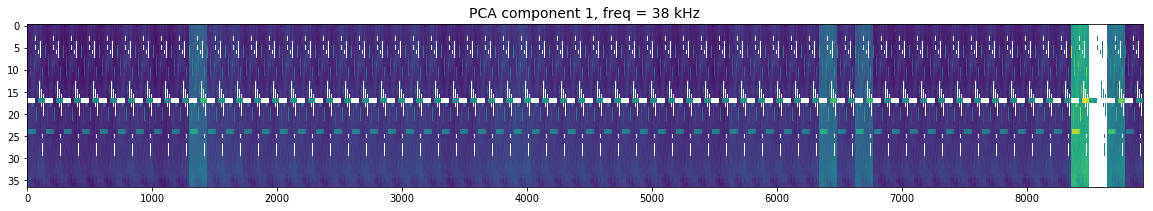

In [35]:
# Component 1
C1_lin = np.expand_dims(u_lin[:,1]*s_lin[1],axis=1)*v_lin[1,:].T
C1_lin_freq1 = C1_lin[:,:ping_per_day_mvbs*37]

plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(10*np.log10(C1_lin_freq1.reshape(62,ping_per_day_mvbs,37)).squeeze()),mode=2), 
           aspect='auto')
plt.title('PCA component 1, freq = 38 kHz', fontsize=14)
plt.show()

/Users/wu-jung/miniconda3/envs/infotaxis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


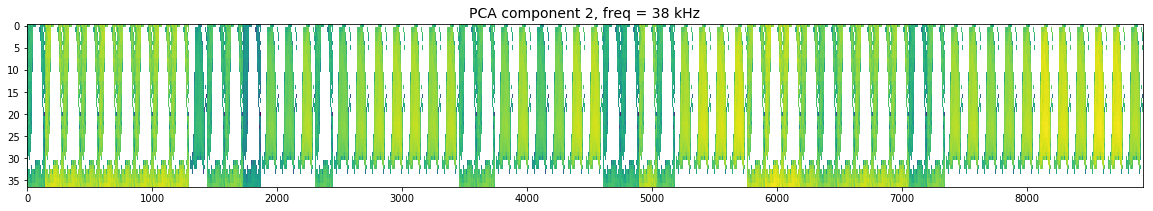

In [36]:
# Component 2
C2_lin = np.expand_dims(u_log[:,2]*s_log[2],axis=1)*v_log[2,:].T
C2_lin_freq1 = C2_lin[:,:ping_per_day_mvbs*37]

plt.figure(figsize=(20,3))
plt.imshow(tl.unfold(tl.tensor(10*np.log10(C2_lin_freq1.reshape(62,ping_per_day_mvbs,37)).squeeze()),mode=2), 
           aspect='auto')
plt.title('PCA component 2, freq = 38 kHz', fontsize=14)
plt.show()